# Evaluate the turbulent sink and source terms in the mixed layer

$$
\frac{1}{2}\frac{\partial u'^2}{\partial t} = \epsilon - \langle u'w'\rangle\frac{\partial u}{\partial z}-J_b + \langle u'p'\rangle + \langle w'p'\rangle
$$
where $\langle u'w'\rangle\frac{\partial u}{\partial z}$ can be approximated with $u^{*3} (kz)^{-1}$. All of these terms have units of buoyancy flux [W/g].

## Compute Monin-Obhukov scale (from heat fluxes and winds only)

Monin Obukho scale is defined as $$L \equiv \frac{-u^{*3}}{\kappa B_0}$$\
with friction velocity $u^{*} = \sqrt{\frac{\tau}{\rho}}$,\
net buoyancy flux at the surface $B_0$,\
and van Karman constant $\kappa = 0.4$.

Since reanalysis heat flux $Q_{net}$ is in [W/m2], it needs to be converted to buoyancy flux in [W/kg] by $B_0 = -g \alpha_T Q_{net}/(\rho c_p)$.

## Estimate how large the (E-P) contribution to Jb would be:

The buoyancy flux in [W/kg] is given by
$$
B = \frac{g\alpha Q}{c_p\rho} + \frac{g\beta(E-P)S}{1-\frac{S}{1000}}
$$
where Q is the upward heat flux [Wm$^{-2}$], evaporation minus precipitation(E-P) in [m/s], S the surface salinity.

In [316]:
%matplotlib inline

import sys
sys.path.append('../src/')

import glob
import warnings

import numpy as np
import pandas as pd
import xarray as xr

from scipy.optimize import curve_fit, minimize

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cmocean import cm
import hvplot.xarray

from sklearn.linear_model import LinearRegression

from epsilon_tools import *
from tools import str2date, avg_funs

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

# set up figure params
sns.set(style='ticks', context='poster', palette='colorblind')
mpl.rc('figure', dpi=100, figsize=[12, 6])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

In [462]:
def qc_turbulence(data):
    '''
    clean chi and eps with RC's scripts
    '''
    # infile = 'data/xarray/xr_7784b.nc'
    # data = xr.open_dataset(str(infile))

    dtdzmin = 1.5e-3
    chimax = 5e-5
    kTmax = 1e-1
    zmin = 0 # disabled
    # for ratios
    lb = 0.5
    ub = 2

    floats = np.array([
        '7779a', '7781a', '7783a', '7786a', '7787a', '7788a',
        '7700b', '7701b','7780b', '7784b', '7785b', '7786b'
    ])
    fi = np.where(floats == data.floatid)[0][0]
    good_chi1, good_chi2 = np.load('../data/xarray/good_chi.npy')

    # 1) thresholds for chi
    data['dtdz1'] = np.sqrt(0.5 * data.chi1 / data.kT1)
    data['dtdz2'] = np.sqrt(0.5 * data.chi2 / data.kT2)

    bad = (data.dtdz1 <= dtdzmin) | (data.chi1 >= chimax) | (data.kT1 >= kTmax) #| (data.z > zmin)
    data['chi1'] = data['chi1'].where(~bad)
    data['kT1'] = data['kT1'].where(~bad)
    data['eps1'] = data['eps1'].where(~bad)

    bad = (data.dtdz2 <= dtdzmin) | (data.chi2 >= chimax) | (data.kT2 >= kTmax) #| (data.z > zmin)
    data['chi2'] = data['chi2'].where(~bad)
    data['kT2'] = data['kT2'].where(~bad)
    data['eps2'] = data['eps2'].where(~bad)

    # 2) periods of functioning chi sensor
    tmin, tmax = str2date(good_chi1[fi, 0]), str2date(good_chi1[fi, 1])
    bad = (data.time < tmin) | (data.time > tmax)
    data['chi1'] = data['chi1'].where(~bad)
    data['kT1'] = data['kT1'].where(~bad)
    data['eps1'] = data['eps1'].where(~bad)

    tmin, tmax = str2date(good_chi2[fi, 0]), str2date(good_chi2[fi, 1])
    bad = (data.time < tmin) | (data.time > tmax)
    data['chi2'] = data['chi2'].where(~bad)
    data['kT2'] = data['kT2'].where(~bad)
    data['eps2'] = data['eps2'].where(~bad)

    # 3) compare two sensors
    def combine_fun(array1, array2, lb=lb, ub=ub):
        ratio = array1 / array2
        bad = (ratio <= lb) | (ratio >= ub)

        chi1fin = np.isfinite(array1)
        chi2fin = np.isfinite(array2)

        a1 = np.minimum(array1.where(bad & chi1fin),
                        array2.where(bad & chi1fin))
        a2 = np.minimum(array1.where(bad & chi2fin),
                        array2.where(bad & chi2fin))
        a3 = avg_funs(array1.where(~bad), array2.where(~bad))

        concat = xr.concat([a1, a2, a3], dim='temp')
        return concat.mean(dim='temp')

    data['kT'] = combine_fun(data.kT1, data.kT2)
    data['chi'] = combine_fun(data.chi1, data.chi2)
    data['eps'] = combine_fun(data.eps1, data.eps2)

    data = data.drop(
        ['eps1', 'eps2', 'chi1', 'chi2', 'kT1', 'kT2', 'dtdz1', 'dtdz2'])
    return data

In [1313]:
floatid = '7781a'
raw = xr.open_dataset(f'../data/xarray/xr_{floatid}.nc')
cfs = xr.open_dataset('../data/metdata/float_cfs_hourly.nc')
cfs = cfs.sel(floatid=f'{floatid}')
emp = xr.open_dataset('../data/CFS/croppped_emp_field.nc')

(-100, 0)

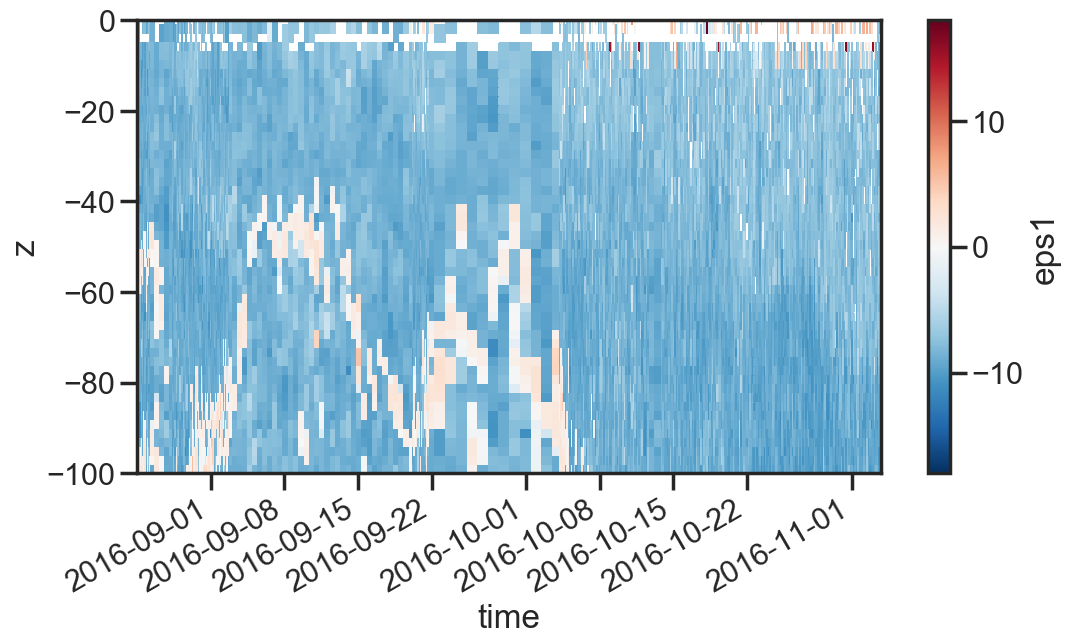

In [1314]:
raw.eps1.pipe(np.log10).plot()
plt.ylim(-100,0)

In [1315]:
raw = qc_turbulence(raw)

(-100, 0)

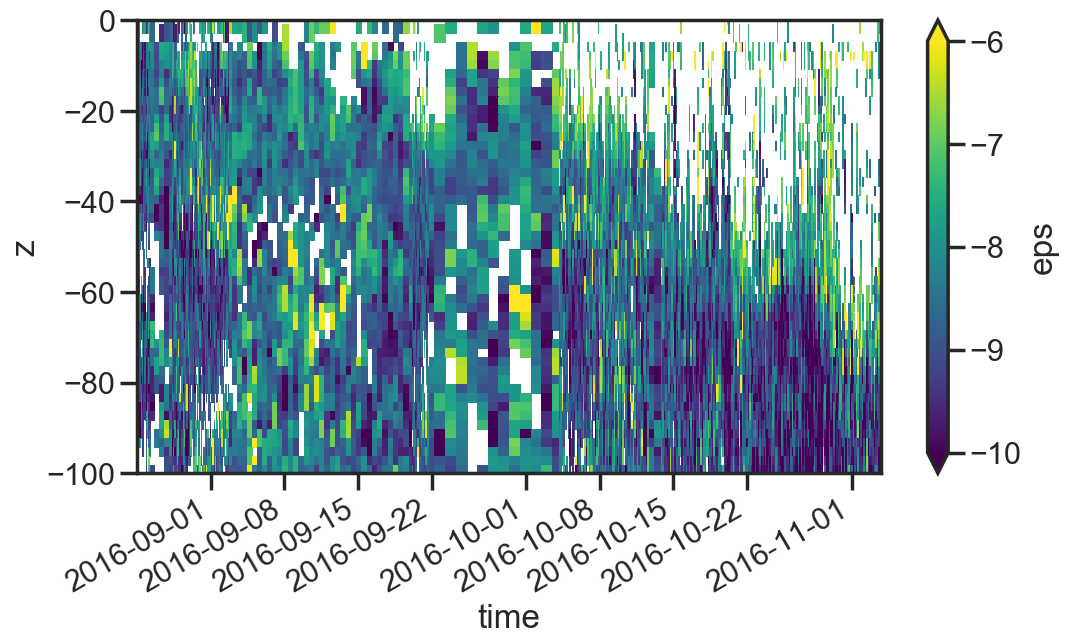

In [1316]:
raw.eps.pipe(np.log10).plot(vmin=-10,vmax=-6)
plt.ylim(-100,0)

In [1317]:
def qc_velocity(data):
    Wmin = 0.05
    RotPmax = 20
    verrmax = 0.02

    # where cond:  what to keep!
    uv_mask = (np.abs(data.W) > Wmin) & (data.RotP < RotPmax)
    u1_mask = uv_mask & (data.verr1 < verrmax)
    u2_mask = uv_mask & (data.verr2 < verrmax)

    data['u1'] = data.u1.where(u1_mask)
    data['u2'] = data.u2.where(u2_mask)
    data['v1'] = data.u1.where(u1_mask)
    data['v2'] = data.v2.where(u2_mask)

    data['u'] = avg_funs(data['u1'], data['u2'])
    data['v'] = avg_funs(data['v1'], data['v2'])
    data['dudz'] = avg_funs(data['du1dz'], data['du2dz'])
    data['dvdz'] = avg_funs(data['dv1dz'], data['dv2dz'])
    data['S2'] = np.sqrt(data.dudz**2 + data.dvdz**2)

    data = data.drop([
        'W', 'RotP', 'verr1', 'verr2', 'u1', 'u2', 'v1', 'v2', 'du1dz',
        'du2dz', 'dv1dz', 'dv2dz'
    ])
    return data

In [1318]:
raw = qc_velocity(raw)

In [1319]:
raw['mld'] = ('time', raw.z.where( raw.S2 == raw.S2.max(dim='z')).mean(dim='z').rolling(time=10, center=True).mean())

In [1320]:
def first_finite(arr, axis):
    '''spits out the indices'''
    mask = arr.notnull()
    return xr.where(mask.any(axis=axis), mask.argmax(axis=axis), np.nan).fillna(0).astype(int)

In [1321]:
def integrate_columns(data,mld):
    '''
        Integrate each profile over mixed layer.
    '''
    # mld=data.mld
    data = data.where( (data.z >= mld) )
    data['z'] = data.z * (-1)
    array = []
    for t in range(data.time.size):
        # TODO: could do better here with simpson's rule
        if data.isel(time=t).dropna('z').size > 3:
            array.append(data.isel(time=t).dropna('z').integrate('z'))
        else:
            array.append(data.isel(time=t).dropna('z').integrate('z')*np.nan)
            
    # find zmin observed depth
    zmin = data[first_finite(data,0)].z
    return xr.concat(array/(mld-zmin), dim='time')

In [1322]:
raw['meps'] = ('time', -integrate_columns(raw.eps, raw.mld))

(-100, 0)

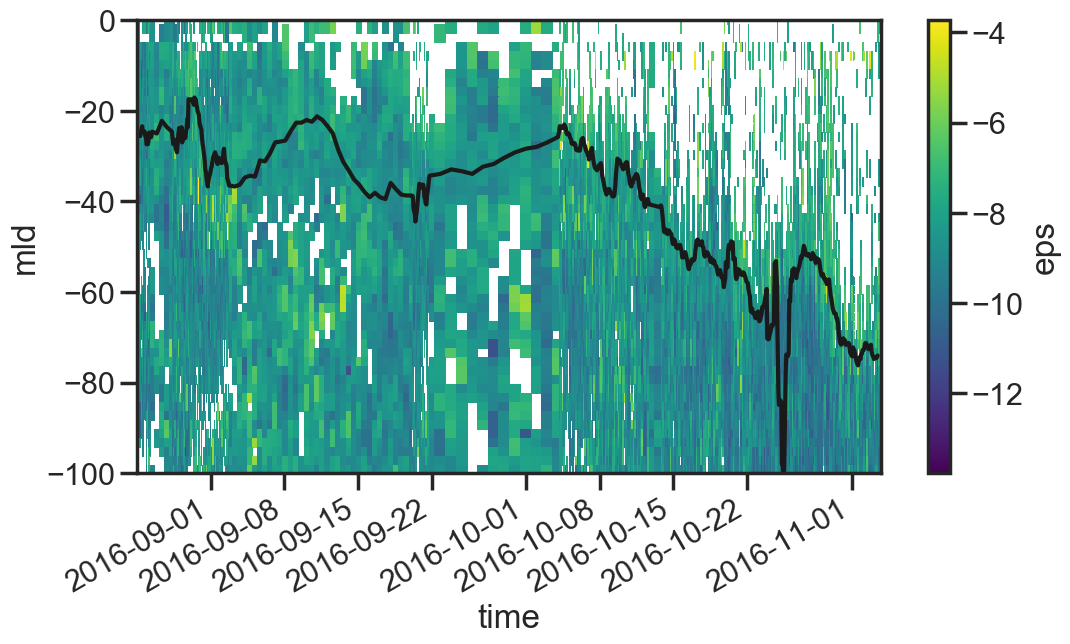

In [1323]:
raw.eps.pipe(np.log10).plot()
raw.mld.plot(color='k')
plt.ylim(-100,0)

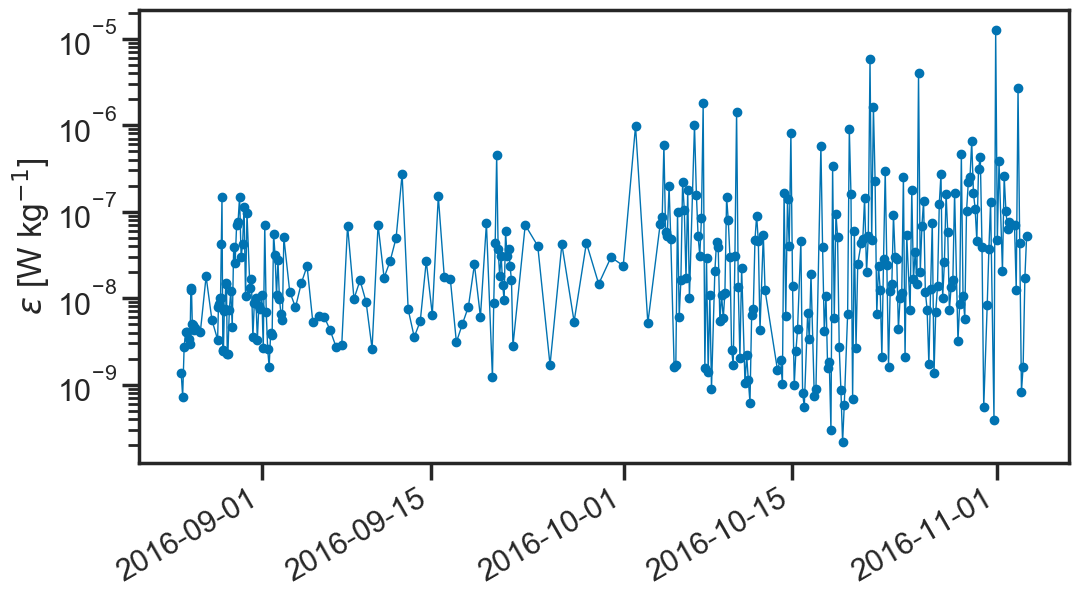

In [1324]:
raw.meps.dropna('time').plot(lw=1,marker='.')
plt.yscale('log')
plt.ylabel(r'$\epsilon$ [W kg$^{-1}$]')
plt.xlabel(None);

Text(0.5, 0, '')

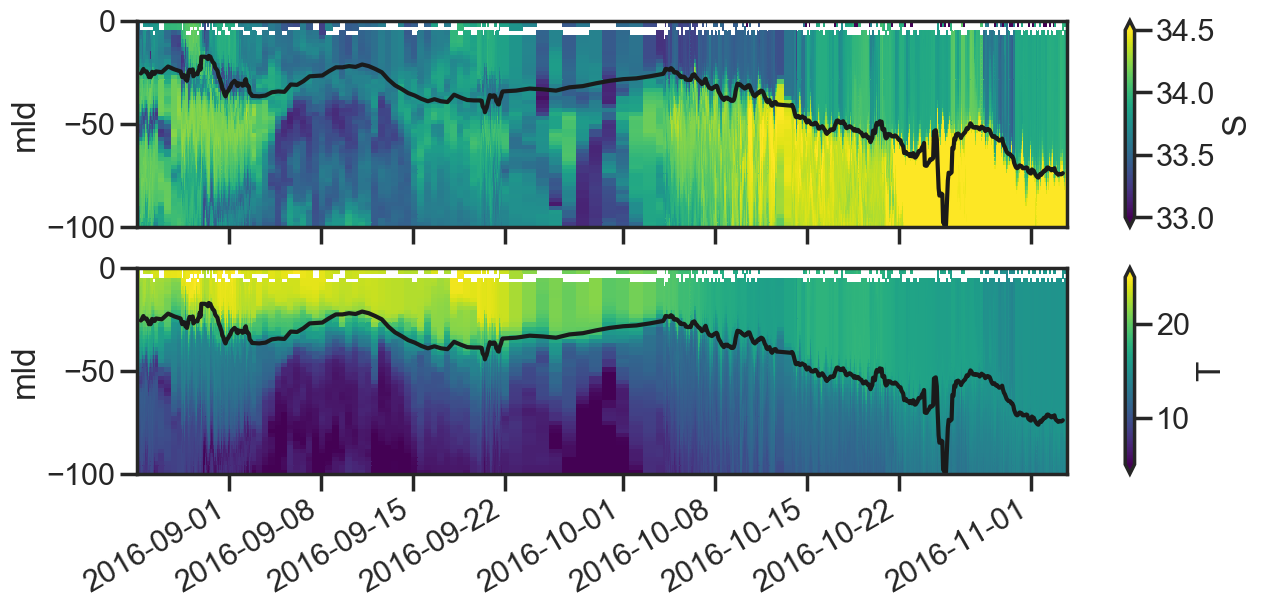

In [1325]:
f,ax = plt.subplots(2,1,figsize=(15,6), sharex=True)
raw.S.plot(vmin=33,vmax=34.5, ax=ax[0])
raw.mld.plot(color='k', ax= ax[0])
ax[0].set_ylim(-100,0)
ax[0].set_xlabel(None)


raw.T.plot(vmin=5,vmax=25, ax=ax[1])
raw.mld.plot(color='k', ax= ax[1])
ax[1].set_ylim(-100,0)
ax[1].set_xlabel(None)

In [1326]:
# extract uppermost velocity measuremnt
indu = first_finite(raw.u, 0).fillna(0).astype(int)
indv = first_finite(raw.v, 0).fillna(0).astype(int)

raw['u_surf'] = raw.u[indu]
raw['v_surf'] = raw.v[indv]

indS = first_finite(raw.S, 0).fillna(0).astype(int)
indT = first_finite(raw.T, 0).fillna(0).astype(int)
raw['S_surf'] = 0.5*(raw.S[indS]+raw.S[indS+1])
raw['T_surf'] = 0.5*(raw.T[indT]+raw.T[indT+1])

In [1327]:

emp = emp.sortby('time').resample(time='1h').mean()
emp = emp.interp_like(raw) # interpolates onto floats time

In [1328]:
def interp_in_space(twod, oned):
    collect = []
    for t in oned.time:
        temp1 = oned.sel(time=t)
        temp2 = twod.sel(time=t)

        if ~temp2.lon.isnull() & ~temp2.lat.isnull():
            collect.append(temp1.interp(lon=temp2.lon,lat=temp2.lat))
    collect = xr.concat(collect,dim='time')
    return collect

In [1329]:
cfs = cfs.interp_like(raw, method='linear')

In [1330]:
rho0=raw.rho0.mean()
g = 9.81

raw['emp'] = ('time', interp_in_space(raw, emp).EMP)
raw['emp'] = raw.emp/(100*86400)
raw['qnet'] = ('time', cfs['Qnet'])
raw['tx'] = ('time', cfs['tx'])
raw['ty'] = ('time', cfs['ty'])
raw['taudotu'] = raw.u_surf * raw.tx + raw.v_surf * raw.ty

raw['tau'] = ('time', np.sqrt( raw.tx**2 + raw.ty**2 ))

raw['uprime'] = np.sqrt( raw.tau/raw.rho0.mean() )
raw['shear_prod'] = -raw.uprime**3/(0.4*raw.z) 
raw['shear_prod'] = raw.shear_prod.transpose('z','time').where( raw.shear_prod<1e5)
raw['mshear_prod'] = ('time', -integrate_columns(raw.shear_prod, raw.mld))

In [1331]:
import gsw
cp = gsw.cp_t_exact(raw.S_surf.mean(),raw.T_surf.mean(),0)
alphaT = gsw.alpha(raw.S_surf.mean(),raw.T_surf.mean(),0)
betaS = gsw.beta(raw.S_surf.mean(),raw.T_surf.mean(),0)

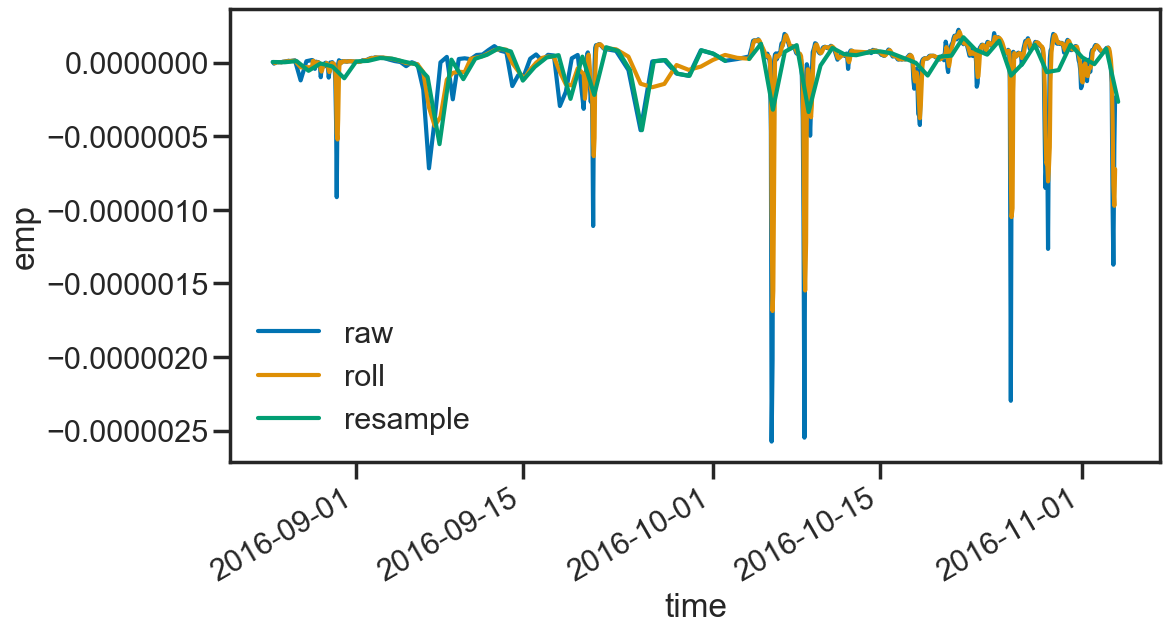

In [1333]:
raw.emp.plot(label='raw')
raw.emp.rolling(time=3).mean().plot(label='roll')
raw.emp.resample(time='D', label='right').mean().plot(label='resample')
plt.legend()

In [1369]:
raw['BQ'] = (g*alphaT*raw.qnet/(cp*rho0))
raw['BEP'] = (g*betaS*raw.emp*raw.S_surf/(1-raw.S_surf/1000))
raw['B'] = (raw.BQ + raw.BEP)
raw['MO'] = -raw.uprime**3/(0.4*raw.B)
raw['MO_MLD'] = -raw.mld/raw.MO

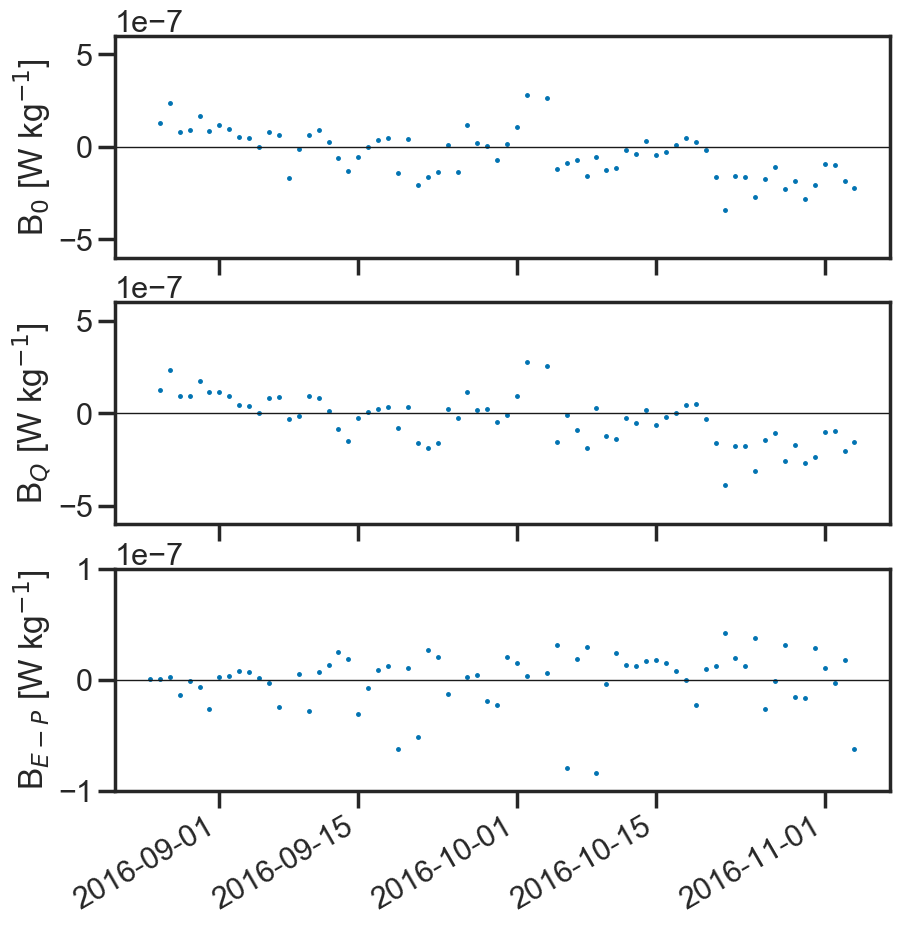

In [1378]:
f,ax=plt.subplots(3,1,sharex=True, figsize=(10,10))
# met['uprime'].plot(ax=ax[0],lw=0,marker='.',ms=2)
# ax[0].set_xlabel(None)
# ax[0].set_ylabel(r'u*')
# ax[0].set_ylim(0,2e-6)

raw['B'].resample(time='D', label='right').mean().plot(ax=ax[0],lw=0,marker='.',ms=5)
ax[0].set_xlabel(None)
ax[0].set_ylabel(r'B$_0$ [W kg$^{-1}$]')
ax[0].set_ylim(-6e-7,6e-7)
ax[0].axhline(0, lw=1, color='k')

raw['BQ'].resample(time='D', label='right').mean().plot(ax=ax[1],lw=0,marker='.',ms=5)
ax[1].set_xlabel(None)
ax[1].set_ylabel(r'B$_Q$ [W kg$^{-1}$]')
ax[1].set_ylim(-6e-7,6e-7)
ax[1].axhline(0, lw=1, color='k')

raw.BEP.resample(time='D', label='right').mean().plot(ax=ax[2],lw=0,marker='.',ms=5)
ax[2].set_xlabel(None)
ax[2].set_ylabel(r'B$_{E-P}$ [W kg$^{-1}$]');
ax[2].set_ylim(-1e-7,1e-7);
ax[2].axhline(0, lw=1, color='k')

plt.savefig('../figures/buoyancy_fluxes.pdf')

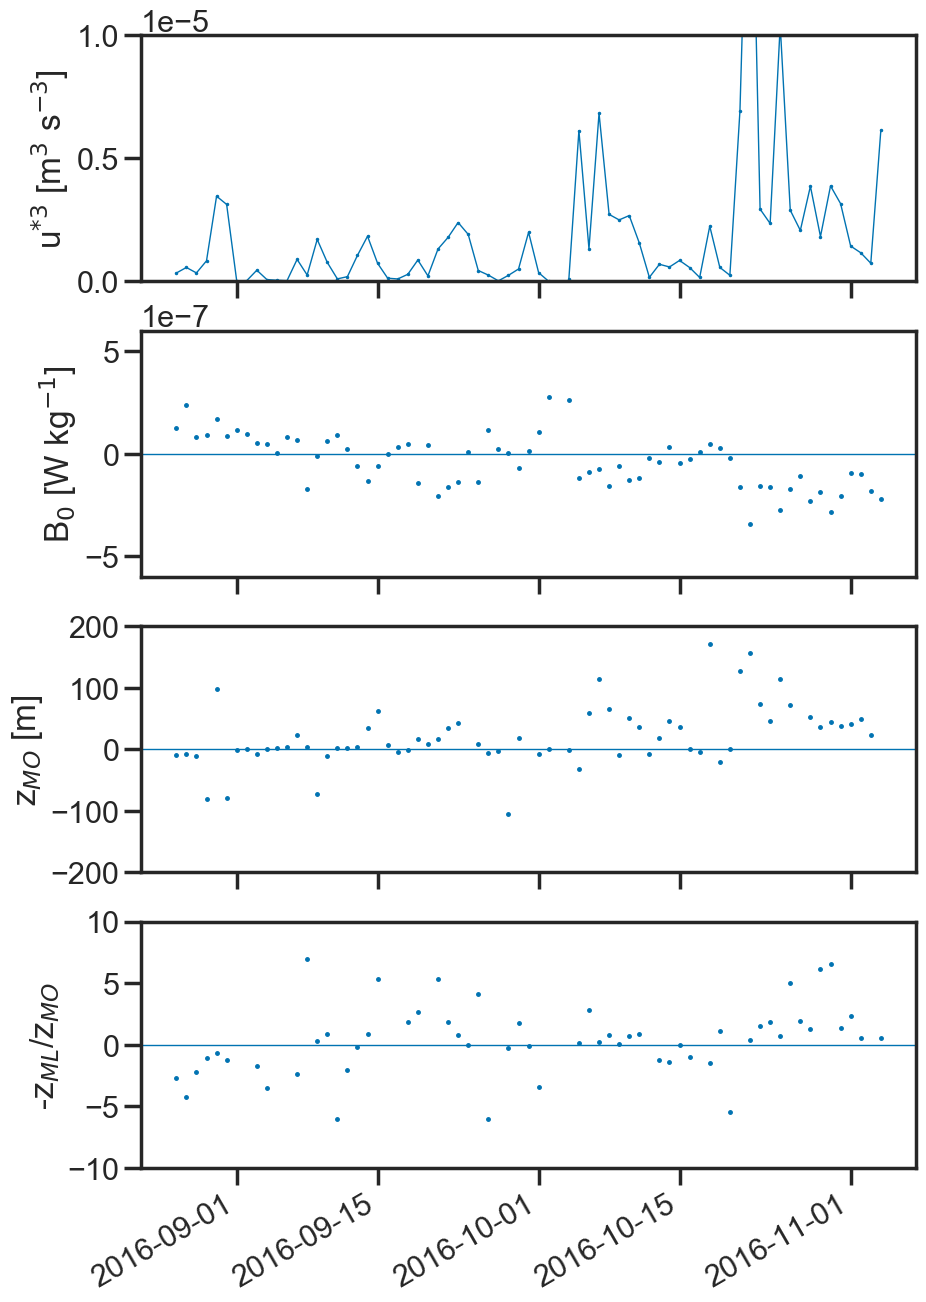

In [1383]:
f,ax=plt.subplots(4,1,sharex=True, figsize=(10,15))
raw['uprime'].resample(time='D', label='right').mean().pipe(np.power,3).plot(ax=ax[0],lw=1,marker='.',ms=3)
ax[0].set_xlabel(None)
ax[0].ticklabel_format(axis='y',style='sci',scilimits=(0,-7))
ax[0].set_ylabel(r'u$^{*3}$ [m$^3$ s$^{-3}$]')
ax[0].set_ylim(0,1e-5)

raw['B'].resample(time='D', label='right').mean().plot(ax=ax[1],lw=0,marker='.',ms=5)
ax[1].set_xlabel(None)
ax[1].set_ylabel(r'B$_0$ [W kg$^{-1}$]')
ax[1].ticklabel_format(axis='y',style='sci',scilimits=(-6,6))
ax[1].set_ylim(-6e-7,6e-7)
ax[1].axhline(0, lw=1)

raw.MO.resample(time='D', label='right').mean().plot(ax=ax[2],lw=0,marker='.',ms=5)
ax[2].set_xlabel(None)
ax[2].set_ylim(-200,200);
ax[2].set_ylabel(r'z$_{MO}$ [m]')
ax[2].axhline(0, lw=1)

raw.MO_MLD.resample(time='D', label='right').mean().plot(ax=ax[3],lw=0,marker='.',ms=5)
ax[3].set_xlabel(None)
ax[3].set_ylim(-10,10);
ax[3].set_ylabel(r'-z$_{ML}$/z$_{MO}$');
ax[3].axhline(0, lw=1)

plt.savefig('../figures/monin_obukhov.pdf')

In [1392]:
raw['taudotu_wg'] = raw.taudotu/(rho0*raw.z)
raw['taudotu_wg'] = raw.taudotu_wg.transpose('z','time').where( raw.taudotu_wg<1e5).where( raw.taudotu_wg>-1e5)
raw['taudotu_wg']  = ('time', -integrate_columns(raw.taudotu_wg, raw.mld))

# raw.to_netcdf(f'../data/turb/turb_{floatid}.nc')

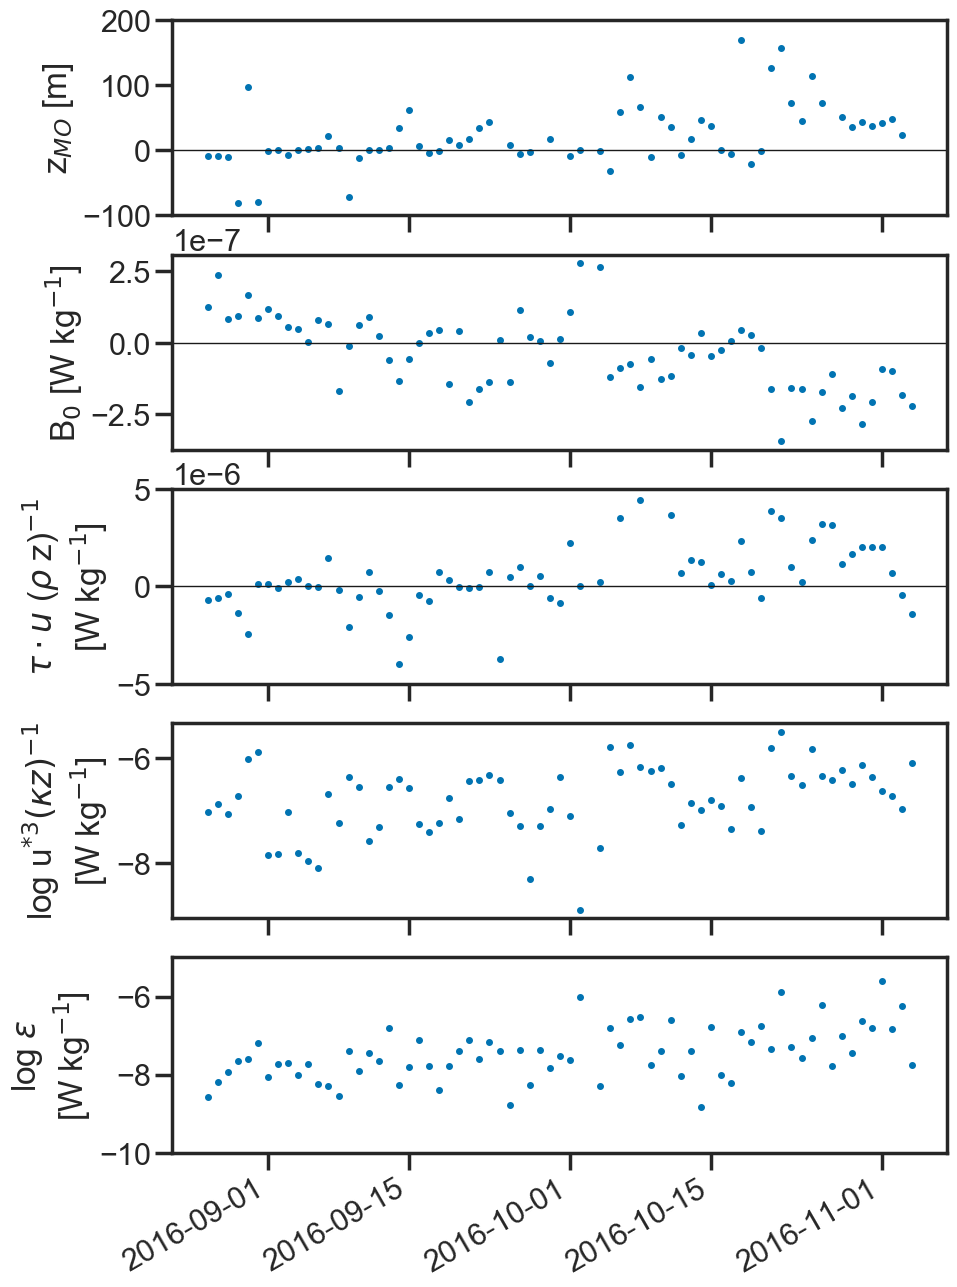

In [1427]:
f,ax=plt.subplots(5,1,sharex=True, figsize=(10,15))

raw.MO.resample(time='D', label='right').mean().dropna('time').plot(ax=ax[0],lw=0,marker='.',ms=8)
ax[0].set_xlabel(None)
ax[0].set_ylim(-100,200);
ax[0].set_ylabel(r'z$_{MO}$ [m]')
ax[0].axhline(0, lw=1, color='k')

raw.B.resample(time='D', label='right').mean().plot(
    ax=ax[1],lw=0,marker='.',ms=8)
ax[1].set_xlabel(None)
ax[1].set_ylabel(r'B$_0$ [W kg$^{-1}$]')
ax[1].axhline(0, lw=1, color='k')

raw.taudotu_wg.resample(time='D', label='right').mean().dropna(dim='time').plot(ax=ax[2],lw=0,marker='.',ms=8)
ax[2].set_xlabel(None)
ax[2].set_ylim(-5e-6,5e-6)
ax[2].set_ylabel(r'$\tau \cdot u$ ($\rho$ z)$^{-1}$' +'\n'+ '[W kg$^{-1}$]')
ax[2].axhline(0, lw=1, color='k')

ax[2].ticklabel_format(axis='y',style='sci', scilimits=(-5e-6,5e-6))

raw['mshear_prod'].resample(time='D', label='right').mean().dropna(dim='time').pipe(np.abs).pipe(np.log10).plot(ax=ax[3],lw=0,marker='.',ms=8)
ax[3].set_xlabel(None)
ax[3].set_ylabel(r'log u$^{*3} (\kappa z)^{-1}$'+'\n'+r'[W kg$^{-1}$]')
# ax[2].set_ylim(-10,-5)

raw.meps.resample(time='D', label='right').mean().dropna(dim='time').pipe(np.abs).pipe(np.log10).plot(ax=ax[4],lw=0,marker='.',ms=8)
ax[4].set_xlabel(None)
ax[4].set_ylim(-10,-5)
ax[4].set_ylabel(r'log $\epsilon$'+'\n'+ '[W kg$^{-1}$]')


plt.savefig('../figures/terms_timeseries.pdf')

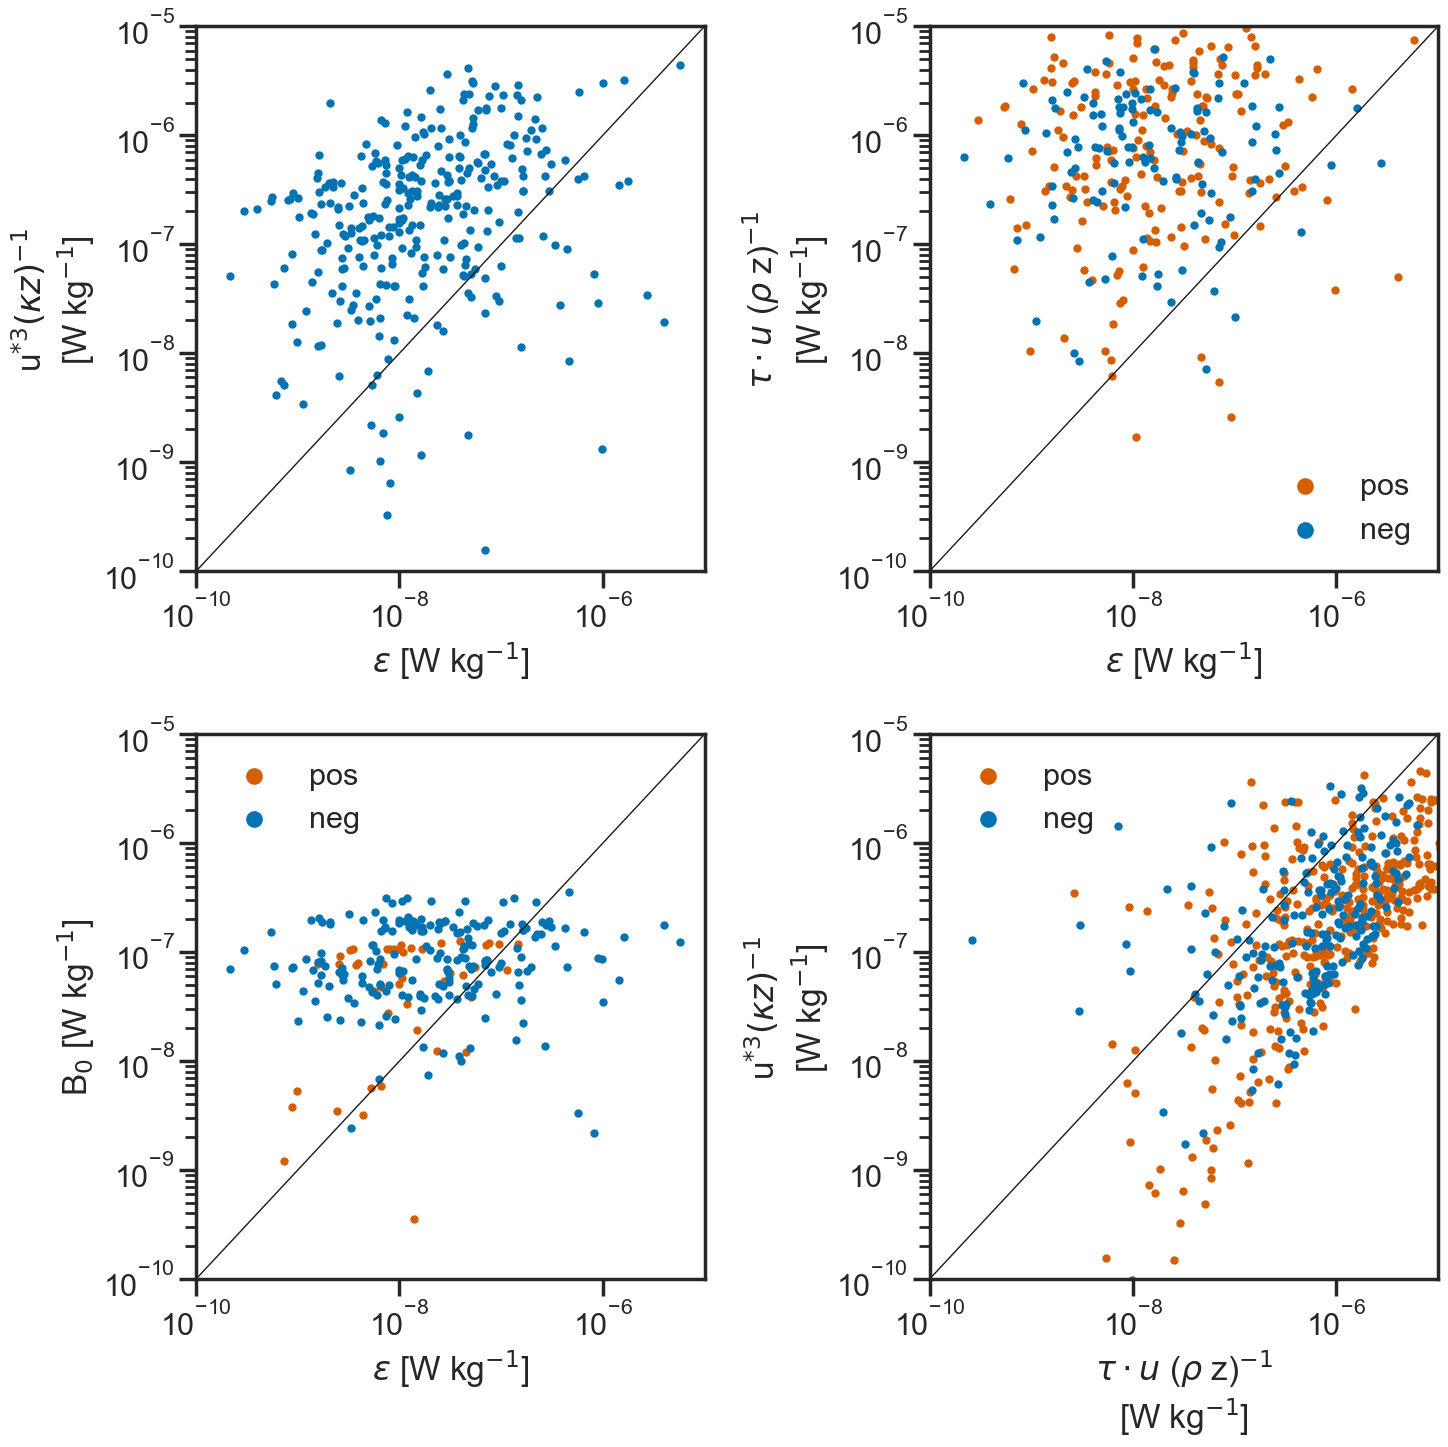

In [1276]:
f,ax=plt.subplots(2,2, figsize=(15,15))
ax = ax.ravel()

xr.plot.scatter(raw,'meps','mshear_prod',marker='.',lw=0,ax=ax[0])
# ax[0].plot(raw.meps,raw.meps,lw=1, marker=None, color='k')
ax[0].plot([1e-10, 1e-5],[1e-10, 1e-5],lw=1, marker=None, color='k')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlim(1e-10,1e-5)
ax[0].set_ylim(1e-10,1e-5);
ax[0].set_xlabel(r'$\epsilon$ [W kg$^{-1}$]')
ax[0].set_ylabel(r'u$^{*3} (\kappa z)^{-1}$'+'\n'+r'[W kg$^{-1}$]')

raw['taudotu+'] = raw.taudotu_wg.where(raw.taudotu_wg>0)
raw['taudotu-'] = np.abs( raw.taudotu_wg.where(raw.taudotu_wg<0) )
xr.plot.scatter(raw,'meps','taudotu+',marker='.',lw=0,ax=ax[1], color='r', label=r'pos')
xr.plot.scatter(raw,'meps','taudotu-',marker='.',lw=0,ax=ax[1], color='b', label=r'neg')
# ax[1].plot(raw.meps,raw.meps,lw=1, marker=None, color='k')
ax[1].plot([1e-10, 1e-5],[1e-10, 1e-5],lw=1, marker=None, color='k')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlim(1e-10,1e-5)
ax[1].set_ylim(1e-10,1e-5);
ax[1].set_xlabel(r'$\epsilon$ [W kg$^{-1}$]')
ax[1].set_ylabel(r'$\tau \cdot u$ ($\rho$ z)$^{-1}$' +'\n'+ '[W kg$^{-1}$]')
ax[1].legend(markerscale=2)

raw['B+'] = raw.B.where(raw.B>0)
raw['B-'] = np.abs( raw.B.where(raw.B<0) )
xr.plot.scatter(raw,'meps','B+',marker='.',lw=0,ax=ax[2], color='r', label=r'pos')
xr.plot.scatter(raw,'meps','B-',marker='.',lw=0,ax=ax[2], color='b', label=r'neg')
# ax[2].plot(raw.meps,raw.meps,lw=1, marker=None, color='k')
ax[2].plot([1e-10, 1e-5],[1e-10, 1e-5],lw=1, marker=None, color='k')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_xlim(1e-10,1e-5)
ax[2].set_ylim(1e-10,1e-5);
ax[2].set_xlabel(r'$\epsilon$ [W kg$^{-1}$]')
ax[2].set_ylabel(r'B$_0$ [W kg$^{-1}$]')
ax[2].legend(markerscale=2)

xr.plot.scatter(raw,'taudotu+','mshear_prod',marker='.',lw=0,ax=ax[3], color='r', label=r'pos')
xr.plot.scatter(raw,'taudotu-','mshear_prod',marker='.',lw=0,ax=ax[3], color='b', label=r'neg')
# ax[3].plot(raw.meps,raw.meps,lw=1, marker=None, color='k')

ax[3].plot([1e-10, 1e-5],[1e-10, 1e-5],lw=1, marker=None, color='k')
ax[3].set_xscale('log')
ax[3].set_yscale('log')
ax[3].set_xlim(1e-10,1e-5)
ax[3].set_ylim(1e-10,1e-5);
ax[3].set_xlabel(r'$\tau \cdot u$ ($\rho$ z)$^{-1}$' +'\n'+ '[W kg$^{-1}$]')
ax[3].set_ylabel(r'u$^{*3} (\kappa z)^{-1}$'+'\n'+r'[W kg$^{-1}$]')
ax[3].legend(markerscale=2)

plt.tight_layout()

plt.savefig('../figures/terms_scatter.pdf')